In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,7)
import pickle

# Предварительный обзор данных
[EDA](https://www.kaggle.com/maximmezhov/cardiospike-eda)

In [2]:
data = pd.read_csv('../input/cardiospikecompetition/train.csv')
data.head()

,id,time,x,y
0,1,0,800,0
1,1,780,780,0
2,1,1572,792,0
3,1,2392,820,0
4,1,3196,804,0


(?)  
**SD** — стандартное отклонение интервалов,  
**RMSSD** — «среднеквадратичное значение последовательных различий», квадратный корень из среднего значения квадратов последовательных различий между соседними интервалами,  
**SDSD** — «стандартное отклонение последовательных различий», стандартное отклонение последовательных различий между соседними интервалами

In [3]:
df = data.copy()

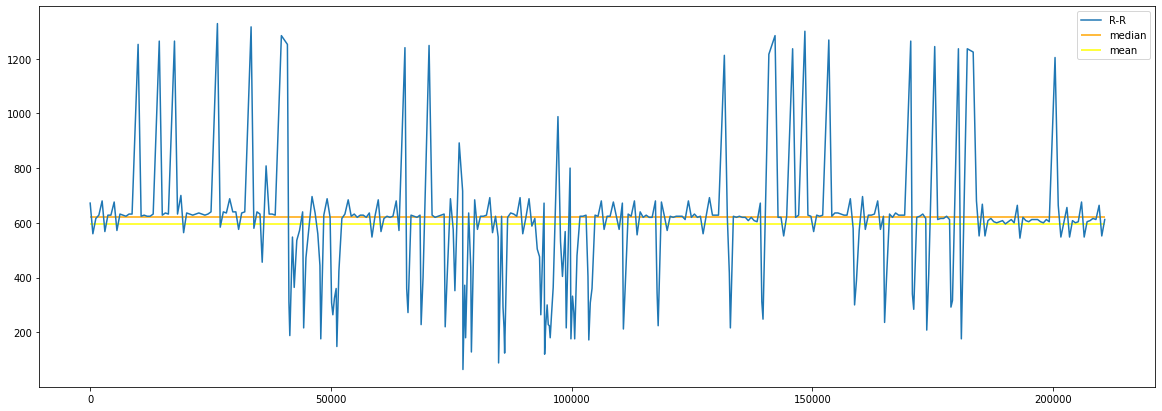

In [4]:
# 246 R-R
fig = plt.figure()
plt.plot(df[df.id==246].time, df[df.id == 246].x, label='R-R')
plt.hlines(df[df.id==246].x.median(),
           df[df.id==246].time.min(),
           df[df.id==246].time.max(), label='median', color='orange')
plt.hlines(df[df.id==246].x.mean(),
           df[df.id==246].time.min(),
           df[df.id==246].time.max(), label='mean', color='yellow')
plt.legend()
plt.show()

# Добавление признаков

In [5]:
ids = df.id.unique()
for rr_id in ids:
    mask = (df.id==rr_id)
    df.loc[mask, 'x_diff'] = df[mask].x.diff()
    df.loc[mask, 'x_deviation_median'] = df[mask].x.median() - df[mask].x.values
    for i in range(1,4):
        # добавим в признаки три следующие точки
        df.loc[mask, f'x+{i}'] = df[mask].x.shift(-i)
        # и три предыдущие точки
        df.loc[mask, f'x-{i}'] = df[mask].x.shift(i)
    df.loc[mask, 'x-(x+1)'] = df[mask].x.values - df.loc[mask, 'x+1'].values
    df.loc[mask, 'x-(x-1)'] = df[mask].x.values - df.loc[mask, 'x-1'].values
    df.loc[mask, 'x-(x+2)'] = df[mask].x.values - df.loc[mask, 'x+2'].values
    df.loc[mask, 'x-(x-2)'] = df[mask].x.values - df.loc[mask, 'x-2'].values
    df.loc[mask, 'x-(x+3)'] = df[mask].x.values - df.loc[mask, 'x+3'].values
    df.loc[mask, 'x-(x-3)'] = df[mask].x.values - df.loc[mask, 'x-3'].values

In [6]:
print('TEST')
print('- всего ритмограмм в наборе данных', len(df.id.unique()), 'штук\n')
print('- в каждой ритмограмме первые и последние три строки \n' \
       'будут с пропусками из-за отсутствия данных о прошлых и будущих точках для \n' \
      'первых и последних трёх точек в радиограмме,\n' \
      'следовательно строк с пропусками должно быть', len(df.id.unique())*6, '\n')
print('- финальный размер датасета должне быть', len(df)-len(df.id.unique())*6, '\n')

print('смотрим, что получается по факту:')
print('df', len(df))
print('df.dropna', len(df.dropna()))
print('разница', len(df) - len(df.dropna()))
if (len(df)-len(df.id.unique())*6 == len(df.dropna())):
    print('Итог: по размеру датасет соответствует ожидаемому, ' \
          'нужно ещё выбрать контрольный пример для оценки глазами')
    print(':)')
else:
    print('Итог: по размерности не сходится... ' \
          'надо проверить алгоритм добавления признаков')
    print(':(')

TEST
- всего ритмограмм в наборе данных 229 штук

- в каждой ритмограмме первые и последние три строки 
будут с пропусками из-за отсутствия данных о прошлых и будущих точках для 
первых и последних трёх точек в радиограмме,
следовательно строк с пропусками должно быть 1374 

- финальный размер датасета должне быть 59113 

смотрим, что получается по факту:
df 60487
df.dropna 59113
разница 1374
Итог: по размеру датасет соответствует ожидаемому, нужно ещё выбрать контрольный пример для оценки глазами
:)


проверка глазами:

In [7]:
mask = (df.id==1)
df[mask].head(10)

,id,time,x,y,x_diff,x_deviation_median,x+1,x-1,x+2,x-2,x+3,x-3,x-(x+1),x-(x-1),x-(x+2),x-(x-2),x-(x+3),x-(x-3)
0,1,0,800,0,NaN,-52.0,780.0,NaN,792.0,NaN,820.0,NaN,20.0,NaN,8.0,NaN,-20.0,NaN
1,1,780,780,0,-20.0,-32.0,792.0,800.0,820.0,NaN,804.0,NaN,-12.0,-20.0,-40.0,NaN,-24.0,NaN
2,1,1572,792,0,12.0,-44.0,820.0,780.0,804.0,800.0,828.0,NaN,-28.0,12.0,-12.0,-8.0,-36.0,NaN
3,1,2392,820,0,28.0,-72.0,804.0,792.0,828.0,780.0,916.0,800.0,16.0,28.0,-8.0,40.0,-96.0,20.0
4,1,3196,804,0,-16.0,-56.0,828.0,820.0,916.0,792.0,960.0,780.0,-24.0,-16.0,-112.0,12.0,-156.0,24.0
5,1,4024,828,0,24.0,-80.0,916.0,804.0,960.0,820.0,956.0,792.0,-88.0,24.0,-132.0,8.0,-128.0,36.0
6,1,4940,916,0,88.0,-168.0,960.0,828.0,956.0,804.0,928.0,820.0,-44.0,88.0,-40.0,112.0,-12.0,96.0
7,1,5900,960,0,44.0,-212.0,956.0,916.0,928.0,828.0,836.0,804.0,4.0,44.0,32.0,132.0,124.0,156.0
8,1,6856,956,0,-4.0,-208.0,928.0,960.0,836.0,916.0,792.0,828.0,28.0,-4.0,120.0,40.0,164.0,128.0
9,1,7784,928,0,-28.0,-180.0,836.0,956.0,792.0,960.0,776.0,916.0,92.0,-28.0,136.0,-32.0,152.0,12.0


In [8]:
# x-(x+2)
916 - 956

-40

In [9]:
mask = (df.id==1)
df[mask].tail(10)

,id,time,x,y,x_diff,x_deviation_median,x+1,x-1,x+2,x-2,x+3,x-3,x-(x+1),x-(x-1),x-(x+2),x-(x-2),x-(x+3),x-(x-3)
1860,1,1393008,776,0,336.0,-28.0,20.0,440.0,332.0,152.0,692.0,196.0,756.0,336.0,444.0,624.0,84.0,580.0
1861,1,1393028,20,0,-756.0,728.0,332.0,776.0,692.0,440.0,620.0,152.0,-312.0,-756.0,-672.0,-420.0,-600.0,-132.0
1862,1,1393360,332,0,312.0,416.0,692.0,20.0,620.0,776.0,640.0,440.0,-360.0,312.0,-288.0,-444.0,-308.0,-108.0
1863,1,1394052,692,0,360.0,56.0,620.0,332.0,640.0,20.0,372.0,776.0,72.0,360.0,52.0,672.0,320.0,-84.0
1864,1,1394672,620,0,-72.0,128.0,640.0,692.0,372.0,332.0,72.0,20.0,-20.0,-72.0,248.0,288.0,548.0,600.0
1865,1,1395312,640,0,20.0,108.0,372.0,620.0,72.0,692.0,840.0,332.0,268.0,20.0,568.0,-52.0,-200.0,308.0
1866,1,1395684,372,0,-268.0,376.0,72.0,640.0,840.0,620.0,668.0,692.0,300.0,-268.0,-468.0,-248.0,-296.0,-320.0
1867,1,1395756,72,0,-300.0,676.0,840.0,372.0,668.0,640.0,NaN,620.0,-768.0,-300.0,-596.0,-568.0,NaN,-548.0
1868,1,1396596,840,0,768.0,-92.0,668.0,72.0,NaN,372.0,NaN,640.0,172.0,768.0,NaN,468.0,NaN,200.0
1869,1,1397264,668,0,-172.0,80.0,NaN,840.0,NaN,72.0,NaN,372.0,NaN,-172.0,NaN,596.0,NaN,296.0


In [10]:
mask = (df.id==3)
display(df[mask].head(10))
display(df[mask].tail(10))

,id,time,x,y,x_diff,x_deviation_median,x+1,x-1,x+2,x-2,x+3,x-3,x-(x+1),x-(x-1),x-(x+2),x-(x-2),x-(x+3),x-(x-3)
2096,3,0,760,0,NaN,28.0,784.0,NaN,772.0,NaN,760.0,NaN,-24.0,NaN,-12.0,NaN,0.0,NaN
2097,3,784,784,0,24.0,4.0,772.0,760.0,760.0,NaN,768.0,NaN,12.0,24.0,24.0,NaN,16.0,NaN
2098,3,1556,772,0,-12.0,16.0,760.0,784.0,768.0,760.0,776.0,NaN,12.0,-12.0,4.0,12.0,-4.0,NaN
2099,3,2316,760,1,-12.0,28.0,768.0,772.0,776.0,784.0,852.0,760.0,-8.0,-12.0,-16.0,-24.0,-92.0,0.0
2100,3,3084,768,1,8.0,20.0,776.0,760.0,852.0,772.0,728.0,784.0,-8.0,8.0,-84.0,-4.0,40.0,-16.0
2101,3,3860,776,1,8.0,12.0,852.0,768.0,728.0,760.0,800.0,772.0,-76.0,8.0,48.0,16.0,-24.0,4.0
2102,3,4712,852,1,76.0,-64.0,728.0,776.0,800.0,768.0,832.0,760.0,124.0,76.0,52.0,84.0,20.0,92.0
2103,3,5440,728,1,-124.0,60.0,800.0,852.0,832.0,776.0,808.0,768.0,-72.0,-124.0,-104.0,-48.0,-80.0,-40.0
2104,3,6240,800,1,72.0,-12.0,832.0,728.0,808.0,852.0,800.0,776.0,-32.0,72.0,-8.0,-52.0,0.0,24.0
2105,3,7072,832,1,32.0,-44.0,808.0,800.0,800.0,728.0,840.0,852.0,24.0,32.0,32.0,104.0,-8.0,-20.0


,id,time,x,y,x_diff,x_deviation_median,x+1,x-1,x+2,x-2,x+3,x-3,x-(x+1),x-(x-1),x-(x+2),x-(x-2),x-(x+3),x-(x-3)
2191,3,74916,848,1,68.0,-60.0,736.0,780.0,768.0,808.0,796.0,792.0,112.0,68.0,80.0,40.0,52.0,56.0
2192,3,75652,736,1,-112.0,52.0,768.0,848.0,796.0,780.0,780.0,808.0,-32.0,-112.0,-60.0,-44.0,-44.0,-72.0
2193,3,76420,768,1,32.0,20.0,796.0,736.0,780.0,848.0,784.0,780.0,-28.0,32.0,-12.0,-80.0,-16.0,-12.0
2194,3,77216,796,1,28.0,-8.0,780.0,768.0,784.0,736.0,796.0,848.0,16.0,28.0,12.0,60.0,0.0,-52.0
2195,3,77996,780,1,-16.0,8.0,784.0,796.0,796.0,768.0,772.0,736.0,-4.0,-16.0,-16.0,12.0,8.0,44.0
2196,3,78780,784,1,4.0,4.0,796.0,780.0,772.0,796.0,804.0,768.0,-12.0,4.0,12.0,-12.0,-20.0,16.0
2197,3,79576,796,0,12.0,-8.0,772.0,784.0,804.0,780.0,796.0,796.0,24.0,12.0,-8.0,16.0,0.0,0.0
2198,3,80348,772,0,-24.0,16.0,804.0,796.0,796.0,784.0,NaN,780.0,-32.0,-24.0,-24.0,-12.0,NaN,-8.0
2199,3,81152,804,0,32.0,-16.0,796.0,772.0,NaN,796.0,NaN,784.0,8.0,32.0,NaN,8.0,NaN,20.0
2200,3,81948,796,0,-8.0,-8.0,NaN,804.0,NaN,772.0,NaN,796.0,NaN,-8.0,NaN,24.0,NaN,0.0


> визуально всё в порядке, проверку на корректность смещения тоже сделал

In [11]:
# сохраним датасет в с текущими признаками, предварительно удалив строки с пропусками
with open('dataset_v1.pkl', 'wb') as f:
    pickle.dump(df.dropna(), f)
    
df.dropna().to_csv('dataset_v1.csv')